# Baixando dados direto do Kaggle


In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fmarcelo","key":"f4cee9575f5505c16169c87dc129b784"}'}

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d antaresnyc/metagenomics

 92% 73.0M/79.6M [00:02<00:00, 33.2MB/s]
100% 79.6M/79.6M [00:02<00:00, 36.8MB/s]


In [ ]:
! unzip metagenomics.zip

Archive:  metagenomics.zip
  inflating: abundance.txt           
  inflating: abundance_stoolsubset.txt  
  inflating: marker_presence.txt     
  inflating: markers2clades_DB.txt   


In [ ]:
# criando pasta para adicinar os dados baixados
! mkdir Metagenome_data

In [ ]:
# movendo arquivos para pasta
! mv ./*.txt ./Metagenome_data/

In [ ]:
! rm metagenomics.zip

# Python

Seção para manipulação do dataframe.

In [ ]:
import os
import pandas as pd
import numpy as np
import re
from scipy.stats import norm
from sklearn.feature_selection import VarianceThreshold

import matplotlib.pyplot as plt

plt.style.use("ggplot")
os.chdir('Metagenome_data/')

In [ ]:
def read_csv(file_name: str) -> pd.core.frame.DataFrame:
  '''
    Function to create and process a dataframe.

    Arguments:
    file_name: str. csv filename

    Returns:
    df: pd.core.frame.Dataframe. dataframe
  '''

  df = pd.read_csv(file_name, sep = '\t', dtype = 'unicode')
  df = df.T
  df.columns = df.iloc[0]
  df.drop(['dataset_name'] , axis = 0, inplace = True)
  
  return df

In [ ]:
data = read_csv('abundance_stoolsubset.txt')
data.head()

dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,paired_end_insert_size,read_length,total_reads,matched_reads,uniquely_matching_reads,uniquely_matched_reads,gene_number,gene_number_for_11m_uniquely_matched_reads,hitchip_probe_number,bmi,gene_count_class,hitchip_probe_class,#SampleID,rna_sampleid,infant_gender,infant_gestation_weeks,cohort,less_than_29weeks,sample_collection_days,collectionweek,samplecollectionwindow,gut_sample_id_ncbipublic,gut_sample_id_corrected,projectid,flowcell,comment,mlst_project,mlst_ec,st_ec,mlst_kp,...,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda|t__GCF_000023465,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__GCF_000294895,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens|t__Enterococcus_pallens_unclassified,k__Bacteria|p__Planctomycetes,k__Bacteria|p__Planctomycetes|c__Planctomycetia,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii|t__Vibrio_furnissii_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4|t__GCF_000157055,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis|t__Lysinibacillus_fusiformis_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus|t__Lysinibacillus_sphaericus_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans|t__GCF_000286375,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus|t__GCF_000286335,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri|t__GCF_00042166

# Analises exploratórias

In [ ]:
# selecting characteristics of interest
metadata = data[['disease', 'age', 'gender', 'country']]

In [ ]:
metadata.head()

dataset_name,disease,age,gender,country
Candela_Africa,n,40,female,tanzania
Candela_Africa.1,n,29,female,tanzania
Candela_Africa.2,n,8,female,tanzania
Candela_Africa.3,n,34,male,tanzania
Candela_Africa.4,n,30,male,tanzania


In [ ]:
# create index
metadata.reset_index(inplace = True)
metadata.rename(columns = {'index' : 'dataset_name'}, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
# rename columns name
metadata.columns.name = None

In [ ]:
metadata.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
# remove missing values from age column
metadata = metadata[(metadata['age'] != 'nd') & (metadata['age'] != 'na') & (metadata['age'] != ' -')]
metadata.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
metadata.age.value_counts()

49       68
59       65
54       57
41       47
44       41
         ..
15        1
9         1
71.71     1
70.86     1
12        1
Name: age, Length: 199, dtype: int64

In [ ]:
# change the age types to float and round up
age_list = np.asarray(metadata['age'], dtype = 'float')
age_list = np.around(age_list)

# chage age valeus
metadata.age = age_list
metadata.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40.0,female,tanzania
1,Candela_Africa.1,n,29.0,female,tanzania
2,Candela_Africa.2,n,8.0,female,tanzania
3,Candela_Africa.3,n,34.0,male,tanzania
4,Candela_Africa.4,n,30.0,male,tanzania


In [ ]:
metadata.dtypes

dataset_name     object
disease          object
age             float64
gender           object
country          object
dtype: object

In [ ]:
# float to int
metadata.age = metadata.age.astype(dtype = 'int')
metadata.dtypes

dataset_name    object
disease         object
age              int64
gender          object
country         object
dtype: object

In [ ]:
metadata.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
def plot_values(values_list: np.ndarray) -> None:
  '''
    Funcao para plotar distribuição de valores.

    Parametros:
    values_list: np.ndarray. Array de valores

    Retorna:
    None
  '''


  # modelando nossos dados - encontrando média e desvio padrao
  mu, std = norm.fit(values_list)

  # plot do histograma
  plt.figure(figsize = (18, 10))
  plt.hist(values_list, bins = 100, density =True, alpha = 0.6, color='g')

  # plot função de densidade de probabilidades
  xmin, xmax = plt.xlim()
  x = np.linspace(xmin, xmax, 100)
  p = norm.pdf(x, mu, std)

  # parametros graficos
  plt.plot(x, p, 'k', linewidth = 2)
  title = "Média = %.2f e Desvio Padrão = %.2f" % (mu, std)
  plt.title(title, fontsize = 18)

  plt.show()

trabalhar sempre com os dados completos.

In [ ]:
# copia de seguranca
df = metadata
df.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
df.disease.value_counts()

n                             722
t2d                           223
ibd_ulcerative_colitis        148
cirrhosis                     118
impaired_glucose_tolerance     49
cancer                         48
n_relative                     47
small_adenoma                  26
ibd_crohn_disease              24
large_adenoma                  13
overweight                     10
-                               6
obese                           5
underweight                     1
Name: disease, dtype: int64

In [ ]:
df[(df.disease != '-')].disease.value_counts()

n                             722
t2d                           223
ibd_ulcerative_colitis        148
cirrhosis                     118
impaired_glucose_tolerance     49
cancer                         48
n_relative                     47
small_adenoma                  26
ibd_crohn_disease              24
large_adenoma                  13
overweight                     10
obese                           5
underweight                     1
Name: disease, dtype: int64

In [ ]:
df = df[(df.disease != '-')]

In [ ]:
df.tail()

,dataset_name,disease,age,gender,country
1984,Zeller_fecal_colorectal_cancer.129,n,63,female,france
1985,Zeller_fecal_colorectal_cancer.130,small_adenoma,66,male,france
1986,Zeller_fecal_colorectal_cancer.131,n,53,female,france
1987,Zeller_fecal_colorectal_cancer.132,cancer,63,male,france
1988,Zeller_fecal_colorectal_cancer.133,cancer,55,female,france


In [ ]:
# verificando generos - todas as doencas devem ter no maximo 2
df.groupby('disease', as_index = False)['gender'].nunique()

,disease,gender
0,cancer,2
1,cirrhosis,2
2,ibd_crohn_disease,2
3,ibd_ulcerative_colitis,2
4,impaired_glucose_tolerance,1
5,large_adenoma,2
6,n,4
7,n_relative,2
8,obese,2
9,overweight,2


In [ ]:
df.gender.unique()

array(['female', 'male', 'na', 'nd'], dtype=object)

In [ ]:
# removendo nd/na
df = df[(df.gender != 'na') & (df.gender != 'nd')]
df.gender.unique()

array(['female', 'male'], dtype=object)

In [ ]:
df.shape

(1288, 5)

In [ ]:
df.groupby('disease', as_index = False)['gender'].nunique()

,disease,gender
0,cancer,2
1,cirrhosis,2
2,ibd_crohn_disease,2
3,ibd_ulcerative_colitis,2
4,large_adenoma,2
5,n,2
6,n_relative,2
7,obese,2
8,overweight,2
9,small_adenoma,2


In [ ]:
# verificando se dados estçao completos
df.groupby('disease', as_index = False).count()

,disease,dataset_name,age,gender,country
0,cancer,48,48,48,48
1,cirrhosis,118,118,118,118
2,ibd_crohn_disease,24,24,24,24
3,ibd_ulcerative_colitis,148,148,148,148
4,large_adenoma,13,13,13,13
5,n,678,678,678,678
6,n_relative,47,47,47,47
7,obese,5,5,5,5
8,overweight,10,10,10,10
9,small_adenoma,26,26,26,26


In [ ]:
df.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
# subset 
df_subset = df[(df.disease == 'ibd_ulcerative_colitis') | (df.disease == 'ibd_crohn_disease') | (df.disease == 'n')]

In [ ]:
df_subset.groupby('disease', as_index = False).count()

,disease,dataset_name,age,gender,country
0,ibd_crohn_disease,24,24,24,24
1,ibd_ulcerative_colitis,148,148,148,148
2,n,678,678,678,678


In [ ]:
# distribuição de paises
df_subset.groupby('country', as_index = False).count()

,country,dataset_name,disease,age,gender
0,china,288,288,288,288
1,denmark,234,234,234,234
2,france,47,47,47,47
3,italy,11,11,11,11
4,peru,20,20,20,20
5,spain,209,209,209,209
6,tanzania,27,27,27,27
7,usa,14,14,14,14


In [ ]:
df_subset.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
df_subset.tail()

,dataset_name,disease,age,gender,country
1980,Zeller_fecal_colorectal_cancer.125,n,65,male,france
1981,Zeller_fecal_colorectal_cancer.126,n,59,female,france
1983,Zeller_fecal_colorectal_cancer.128,n,52,male,france
1984,Zeller_fecal_colorectal_cancer.129,n,63,female,france
1986,Zeller_fecal_colorectal_cancer.131,n,53,female,france


In [ ]:
df_subset.reset_index(inplace = True)
df_subset.drop(['index'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df_subset.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
df_subset.tail()

,dataset_name,disease,age,gender,country
845,Zeller_fecal_colorectal_cancer.125,n,65,male,france
846,Zeller_fecal_colorectal_cancer.126,n,59,female,france
847,Zeller_fecal_colorectal_cancer.128,n,52,male,france
848,Zeller_fecal_colorectal_cancer.129,n,63,female,france
849,Zeller_fecal_colorectal_cancer.131,n,53,female,france


In [ ]:
df_subset.disease.describe()

count     850
unique      3
top         n
freq      678
Name: disease, dtype: object

In [ ]:
df_subset.shape

(850, 5)

In [ ]:
# recolhendo ids do dataset processado
df_clean = df_subset.dataset_name
len(df_clean)

850

In [ ]:
metadata.head()

,dataset_name,disease,age,gender,country
0,Candela_Africa,n,40,female,tanzania
1,Candela_Africa.1,n,29,female,tanzania
2,Candela_Africa.2,n,8,female,tanzania
3,Candela_Africa.3,n,34,male,tanzania
4,Candela_Africa.4,n,30,male,tanzania


In [ ]:
metadata.tail()

,dataset_name,disease,age,gender,country
1984,Zeller_fecal_colorectal_cancer.129,n,63,female,france
1985,Zeller_fecal_colorectal_cancer.130,small_adenoma,66,male,france
1986,Zeller_fecal_colorectal_cancer.131,n,53,female,france
1987,Zeller_fecal_colorectal_cancer.132,cancer,63,male,france
1988,Zeller_fecal_colorectal_cancer.133,cancer,55,female,france


In [ ]:
# dataset bruto
data.reset_index(inplace = True)
data.rename(columns = {'index' : 'dataset_name'}, inplace = True)
data.columns.name = None

In [ ]:
# recolhendo rows que passaram no préprocessamento pelo id dataset_name
df_genus = data.loc[(data.dataset_name.isin(df_clean))]
df_genus.head()

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,paired_end_insert_size,read_length,total_reads,matched_reads,uniquely_matching_reads,uniquely_matched_reads,gene_number,gene_number_for_11m_uniquely_matched_reads,hitchip_probe_number,bmi,gene_count_class,hitchip_probe_class,#SampleID,rna_sampleid,infant_gender,infant_gestation_weeks,cohort,less_than_29weeks,sample_collection_days,collectionweek,samplecollectionwindow,gut_sample_id_ncbipublic,gut_sample_id_corrected,projectid,flowcell,comment,mlst_project,mlst_ec,st_ec,...,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda|t__GCF_000023465,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__GCF_000294895,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens|t__Enterococcus_pallens_unclassified,k__Bacteria|p__Planctomycetes,k__Bacteria|p__Planctomycetes|c__Planctomycetia,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii|t__Vibrio_furnissii_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4|t__GCF_000157055,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis|t__Lysinibacillus_fusiformis_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus|t__Lysinibacillus_sphaericus_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans|t__GCF_000286375,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus|t__GCF_000286335,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri|t__GCF_000421665,k__Ba

In [ ]:
df_genus.dropna(axis=0, inplace = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
# adicionando no dataset original colunas processadas
df_genus.gender = df_subset.gender
df_genus.disease = df_subset.disease
df_genus.age = df_subset.age

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df_genus.shape

(323, 2339)

In [ ]:
df_genus.tail()

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,paired_end_insert_size,read_length,total_reads,matched_reads,uniquely_matching_reads,uniquely_matched_reads,gene_number,gene_number_for_11m_uniquely_matched_reads,hitchip_probe_number,bmi,gene_count_class,hitchip_probe_class,#SampleID,rna_sampleid,infant_gender,infant_gestation_weeks,cohort,less_than_29weeks,sample_collection_days,collectionweek,samplecollectionwindow,gut_sample_id_ncbipublic,gut_sample_id_corrected,projectid,flowcell,comment,mlst_project,mlst_ec,st_ec,...,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda|t__GCF_000023465,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__GCF_000294895,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens|t__Enterococcus_pallens_unclassified,k__Bacteria|p__Planctomycetes,k__Bacteria|p__Planctomycetes|c__Planctomycetia,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii|t__Vibrio_furnissii_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4|t__GCF_000157055,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis|t__Lysinibacillus_fusiformis_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus|t__Lysinibacillus_sphaericus_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans|t__GCF_000286375,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus|t__GCF_000286335,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri|t__GCF_000421665,k__Ba

In [ ]:
columns = df_genus.columns 

In [ ]:
def Find(pattern:str, txt:str) -> str:
  '''
    Função para buscar padrao em string. Se o padrao eh encontrado, retorna padrao.


    Argumentos:
    pattern: str. padrao procurado.
    txt: str. string onde o padrao sera procurado

    Return:
    match.group(): str ou None. Se encontrar padrao, retorna padrao, caso contrario
    None.
  '''

  match = re.search(pattern, txt)

  if match: return match.group()

In [ ]:
df_genus.head()

,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp,paired_end_insert_size,read_length,total_reads,matched_reads,uniquely_matching_reads,uniquely_matched_reads,gene_number,gene_number_for_11m_uniquely_matched_reads,hitchip_probe_number,bmi,gene_count_class,hitchip_probe_class,#SampleID,rna_sampleid,infant_gender,infant_gestation_weeks,cohort,less_than_29weeks,sample_collection_days,collectionweek,samplecollectionwindow,gut_sample_id_ncbipublic,gut_sample_id_corrected,projectid,flowcell,comment,mlst_project,mlst_ec,st_ec,...,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda,k__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Zunongwangia|s__Zunongwangia_profunda|t__GCF_000023465,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_faecium|t__GCF_000294895,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_pallens|t__Enterococcus_pallens_unclassified,k__Bacteria|p__Planctomycetes,k__Bacteria|p__Planctomycetes|c__Planctomycetia,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula,k__Bacteria|p__Planctomycetes|c__Planctomycetia|o__Planctomycetales|f__Planctomycetaceae|g__Rhodopirellula|s__Rhodopirellula_unclassified,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Vibrionales|f__Vibrionaceae|g__Vibrio|s__Vibrio_furnissii|t__Vibrio_furnissii_unclassified,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides|s__Bacteroides_sp_2_2_4|t__GCF_000157055,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_fusiformis|t__Lysinibacillus_fusiformis_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_sphaericus|t__Lysinibacillus_sphaericus_unclassified,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium,k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae|g__Methanobacterium|s__Methanobacterium_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Lysinibacillus|s__Lysinibacillus_boronitolerans|t__GCF_000286375,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Staphylococcaceae|g__Staphylococcus|s__Staphylococcus_vitulinus|t__GCF_000286335,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Bavariicoccus|s__Bavariicoccus_seileri|t__GCF_000421665,k__Ba

In [ ]:
# buscando todas as colunas do reino bacteria
column_names = [s for i, s in enumerate(columns) if 'k__Bacteria' in s]

In [ ]:
# buscando apenas as colunas que representam os generos
genero_names = []

# demora um pouquinho
for i in range(len(column_names)):
  # re para buscar generos
  aux = Find(r'\w+.\w+.\w+.\w+.\w+.g__\w+$', column_names[i])
  if aux != None:
    genero_names.append(aux)

In [ ]:
genero_names.insert(0, 'disease')
genero_names.insert(1, 'dataset_name')
genero_names.insert(2, 'age')
genero_names.insert(3, 'gender')
genero_names.insert(4, 'country')

In [ ]:
genero_names[0:5]

['disease', 'dataset_name', 'age', 'gender', 'country']

In [ ]:
# recolhendo colunas de interesse
df_genus = df_genus.loc[: , genero_names]
df_genus.head()

,disease,dataset_name,age,gender,country,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,...,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas,k__Bacteria|p__Firmicutes|c__Bacilli|o__Bacillales|f__Bacillaceae|g__Gracilibacillus,k__Bacteria|p__Proteobacter

In [ ]:
columns = []

for i in range(5, len(df_genus.columns)):
  # re para cortar apenas nome dos generos
  aux = re.split(r'\w+.\w+.\w+.\w+.\w+.g__', df_genus.columns[i])
  columns.append(aux[1])

In [ ]:
# inserindo nome colunas nos metadados
columns.insert(0, 'disease')
columns.insert(1, 'dataset_name')
columns.insert(2, 'age')
columns.insert(3, 'gender')
columns.insert(4, 'country')

In [ ]:
df_genus.columns = columns

In [ ]:
df_genus.head()

,disease,dataset_name,age,gender,country,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
0,n,Candela_Africa,40.0,female,tanzania,0,0,0,0.26996,0,0,0,0,0.27587,0,0,0,0.00508,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.0007,0.01178,0.00823,0,0.1677,0.01123,0,0.03933,0.42892,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,n,Candela_Africa.1,29.0,female,tanzania,0,0,0,0.10173,0,0,0,0,0.39064,0,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0,0,0.00243,0.14911,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,n,Candela_Africa.2,8.0,female,tanzania,0,0,0,0.20631,0,0,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0,0.43139,0,0,0,0.33568,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,n,Candela_Africa.3,34.0,male,tanzania,0,0,0,0,0,0,0,0,1.55269,0,0,0,0.00293,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,n,Candela_Africa.4,30.0,male,tanzania,0,0.01332,0,0.03352,0,0,0,0,4.1213,0,0,0,0.04552,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0.0148,0,0,0,0,0,0,0,0,0.00394,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_genus.shape

(850, 275)

In [ ]:
# recolhendo apenas colunas com os generos bacterianos
aux = df_genus.iloc[:,5:]
# tranformando tipo dos dados
aux = aux.astype("float")

# ordenando colunas por abundancia
s = aux.sum(axis=0, numeric_only=True)
aux = aux[s.sort_values(ascending=False).index[:270]]

In [ ]:
aux.head()

,Bacteroides,Eubacterium,Prevotella,Faecalibacterium,Subdoligranulum,Ruminococcus,Alistipes,Roseburia,Parabacteroides,Blautia,Butyrivibrio,Coprococcus,Bifidobacterium,Lachnospiraceae_noname,Escherichia,Dialister,Clostridium,Barnesiella,Dorea,Megamonas,Phascolarctobacterium,Streptococcus,Akkermansia,Erysipelotrichaceae_noname,Odoribacter,Paraprevotella,Treponema,Collinsella,Catenibacterium,Oscillibacter,Sutterella,Veillonella,Klebsiella,Bilophila,Haemophilus,Megasphaera,Bacteroidales_noname,Acidaminococcus,Peptostreptococcaceae_noname,Lactobacillus,...,Rhodopirellula,Fretibacterium,Pseudonocardia,Cryptobacterium,Catonella,Kingella,Bacteroidetes_noname,Janthinobacterium,Marinilabiliaceae_unclassified,Zunongwangia,Cellulosilyticum,Candidatus_Moranella,Anoxybacillus,Kosakonia,Lysinibacillus,Brevibacillus,Eremococcus,Xanthomonas,Serratia,Cardiobacterium,Curvibacter,Thermus,Arcobacter,Mobiluncus,Dolosigranulum,Shuttleworthia,Afipia,Sphingomonas,Ralstonia,Limnohabitans,Centipeda,Polaromonas,Pectobacterium,Brachybacterium,Tannerella,Mogibacterium,Eubacteriaceae_noname,Johnsonella,Filifactor,Desulfotomaculum
0,0.0,15.23832,29.71884,11.25515,1.83878,1.45915,0.0007,4.10987,0.08117,0.38641,0.00000,2.84218,0.0,0.26212,16.48580,0.0,0.00000,0.0,0.36060,0.0,2.64931,0.42892,0.0,0.23478,0.0,0.0,9.22538,0.27587,0.03772,0.01410,0.0,0.14772,0.57308,0.0,0.57017,0.0,0.0,0.0,0.03760,0.16770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,9.41078,26.31152,14.12600,2.18824,1.35866,0.0000,3.36090,0.12985,0.46005,0.00000,0.66964,0.0,0.41714,24.79140,0.0,0.00000,0.0,0.54694,0.0,3.64684,0.14911,0.0,0.48389,0.0,0.0,8.20223,0.39064,0.05287,0.02009,0.0,0.09472,0.86523,0.0,0.30092,0.0,0.0,0.0,0.09181,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,15.80752,29.18548,9.78486,1.75567,1.04376,0.0000,3.93266,0.00000,0.84735,0.00000,0.44330,0.0,0.36441,19.91142,0.0,0.00000,0.0,0.75479,0.0,2.75082,0.33568,0.0,0.26008,0.0,0.0,9.11376,0.19566,0.00000,0.00273,0.0,0.05380,0.52641,0.0,0.29878,0.0,0.0,0.0,0.00000,0.43139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,2.80943,28.66139,19.15665,4.07748,6.37662,0.0000,0.38569,0.14399,1.59346,0.00000,0.50777,0.0,0.32133,0.02486,0.0,0.00000,0.0,0.54454,0.0,14.55914,0.00000,0.0,4.01685,0.0,0.0,14.30572,1.55269,0.00000,0.03959,0.0,0.13852,0.01950,0.0,0.05821,0.0,0.0,0.0,0.07568,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,2.16679,23.31681,30.60823,4.06612,5.48605,0.0148,0.23050,0.08276,0.90730,0.00394,0.51095,0.0,0.29301,0.09242,0.0,0.00394,0.0,0.48473,0.0,16.99198,0.00000,0.0,1.96345,0.0,0.0,7.64717,4.12130,0.00000,0.06677,0.0,0.13856,0.05366,0.0,0.12030,0.0,0.0,0.0,0.02739,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# recolhendo columns names
features_names = aux.columns

In [ ]:
# verificando tipo dos dados
aux = aux.astype('float')
aux.dtypes

Bacteroides              float64
Eubacterium              float64
Prevotella               float64
Faecalibacterium         float64
Subdoligranulum          float64
                          ...   
Mogibacterium            float64
Eubacteriaceae_noname    float64
Johnsonella              float64
Filifactor               float64
Desulfotomaculum         float64
Length: 270, dtype: object

In [ ]:
var_in_genus = np.var(aux, axis = 0)

In [ ]:
max(var_in_genus)

386.8216100796875

In [ ]:
min(var_in_genus)

0.0

In [ ]:
np.mean(var_in_genus)

4.328911731338147

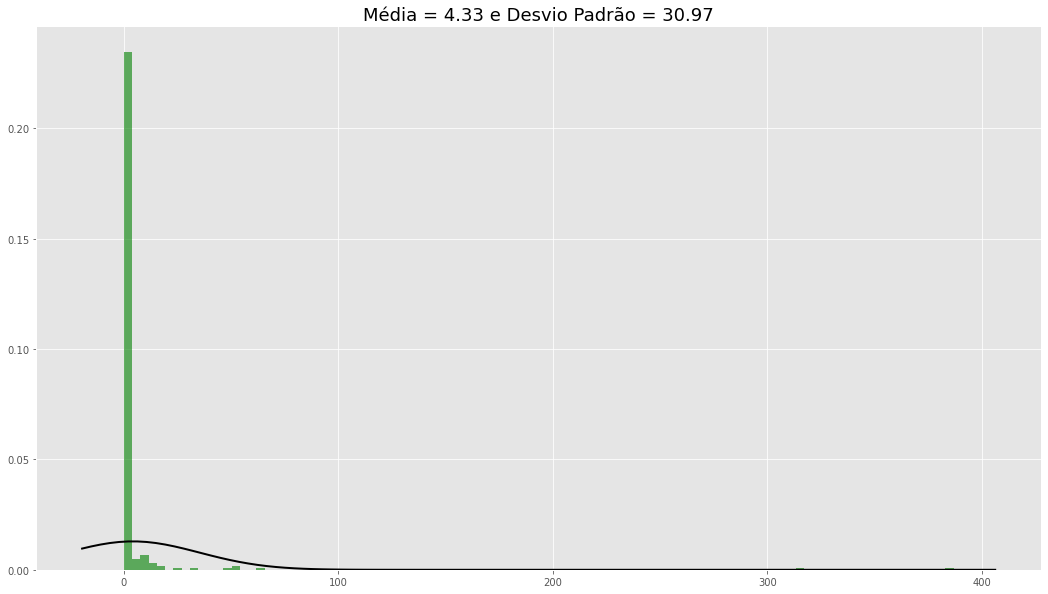

In [ ]:
plot_values(var_in_genus)

### Seleção de caracteristicas - VarianceThreshold

In [ ]:
matrix = aux.to_numpy()
matrix

array([[ 0.     , 15.23832, 29.71884, ...,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  9.41078, 26.31152, ...,  0.     ,  0.     ,  0.     ],
       [ 0.     , 15.80752, 29.18548, ...,  0.     ,  0.     ,  0.     ],
       ...,
       [15.33106,  1.70458,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [ 1.42481, 14.48137,  0.     , ...,  0.     ,  0.     ,  0.     ],
       [29.49368, 17.27934, 13.13384, ...,  0.     ,  0.     ,  0.     ]])

In [ ]:
# selecionando features cuja vairancia é menor que threshould
features_selection = VarianceThreshold(threshold=(15))

In [ ]:
features = features_selection.fit_transform(matrix).shape

In [ ]:
indices_features = features_selection.get_support(indices = True)

In [ ]:
# quantidade de generos selecionados
len(indices_features)

11

In [ ]:
# recolhendo generos selecionados por index do dataframe original
df = aux.iloc[:,indices_features]
df.head()

,Bacteroides,Eubacterium,Prevotella,Faecalibacterium,Subdoligranulum,Ruminococcus,Alistipes,Roseburia,Butyrivibrio,Escherichia,Megamonas
0,0.0,15.23832,29.71884,11.25515,1.83878,1.45915,0.0007,4.10987,0.00000,16.48580,0.0
1,0.0,9.41078,26.31152,14.12600,2.18824,1.35866,0.0000,3.36090,0.00000,24.79140,0.0
2,0.0,15.80752,29.18548,9.78486,1.75567,1.04376,0.0000,3.93266,0.00000,19.91142,0.0
3,0.0,2.80943,28.66139,19.15665,4.07748,6.37662,0.0000,0.38569,0.00000,0.02486,0.0
4,0.0,2.16679,23.31681,30.60823,4.06612,5.48605,0.0148,0.23050,0.00394,0.09242,0.0


In [ ]:
df.shape

(850, 11)

In [ ]:
df_genus.head()

,disease,dataset_name,age,gender,country,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
0,n,Candela_Africa,40.0,female,tanzania,0,0,0,0.26996,0,0,0,0,0.27587,0,0,0,0.00508,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.0007,0.01178,0.00823,0,0.1677,0.01123,0,0.03933,0.42892,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,n,Candela_Africa.1,29.0,female,tanzania,0,0,0,0.10173,0,0,0,0,0.39064,0,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0,0,0.00243,0.14911,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,n,Candela_Africa.2,8.0,female,tanzania,0,0,0,0.20631,0,0,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0,0.43139,0,0,0,0.33568,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,n,Candela_Africa.3,34.0,male,tanzania,0,0,0,0,0,0,0,0,1.55269,0,0,0,0.00293,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,n,Candela_Africa.4,30.0,male,tanzania,0,0.01332,0,0.03352,0,0,0,0,4.1213,0,0,0,0.04552,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0.0148,0,0,0,0,0,0,0,0,0.00394,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_genus.tail()

,disease,dataset_name,age,gender,country,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
1980,NaN,Zeller_fecal_colorectal_cancer.125,NaN,NaN,france,0,0,0,0,5.78432,0,0,0.00134,0,0,0.45801,0,0,0,18.18832,0,0,0,0,6.9355,0,0,2.82097,0.50438,0.42369,0,0.01227,0.12314,0.02196,0,0,0,16.96621,4.46611,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1981,NaN,Zeller_fecal_colorectal_cancer.126,NaN,NaN,france,0,0,0,0,1.2045,0,0,0,0.1587,0,0,0,0,0,18.0012,0.01184,0,0.00505,0.8348,0.39727,0,0,0,0,0.6338,0,0,0.50991,0,0,0,0,0.24355,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1983,NaN,Zeller_fecal_colorectal_cancer.128,NaN,NaN,france,0,0.02586,0,0.01533,3.46624,0,0,0.00055,2.80569,0,0.11429,0.01246,0,0,15.33106,0,0,0,0.18133,3.13483,0,0,1.28154,0,0.69276,0,0.00273,1.25848,0,0,0,0.08602,4.69151,0.64474,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1984,NaN,Zeller_fecal_colorectal_cancer.129,NaN,NaN,france,0,0.06793,0.00325,0.00114,3.7769,0.00208,0.08053,0.00371,1.41715,0.01147,0.00037,0,0,0.13706,1.42481,0.01977,0.21147,0,0.15911,0.30747,0,0,0,0,0.4343,0,0.00199,0,0.01082,0.0037,0,0.01684,0.8817,0.38553,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1986,NaN,Zeller_fecal_colorectal_cancer.131,NaN,NaN,france,0,0,0,0,0,0,0,0,0.04387,0,0,0,0,0,29.49368,0,0.42341,0,0.16072,1.23069,0,0,0,13.13384,0.27627,0,0.01353,0,0,0,0,0,0.03245,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# adicionando metadados as features selecionadas
df.insert(loc = 0, column = 'disease', value = df_genus.disease)
df.insert(loc = 1, column = 'dataset_name', value = df_genus.dataset_name)
df.head()

,disease,dataset_name,Bacteroides,Eubacterium,Prevotella,Faecalibacterium,Subdoligranulum,Ruminococcus,Alistipes,Roseburia,Butyrivibrio,Escherichia,Megamonas
0,n,Candela_Africa,0.0,15.23832,29.71884,11.25515,1.83878,1.45915,0.0007,4.10987,0.00000,16.48580,0.0
1,n,Candela_Africa.1,0.0,9.41078,26.31152,14.12600,2.18824,1.35866,0.0000,3.36090,0.00000,24.79140,0.0
2,n,Candela_Africa.2,0.0,15.80752,29.18548,9.78486,1.75567,1.04376,0.0000,3.93266,0.00000,19.91142,0.0
3,n,Candela_Africa.3,0.0,2.80943,28.66139,19.15665,4.07748,6.37662,0.0000,0.38569,0.00000,0.02486,0.0
4,n,Candela_Africa.4,0.0,2.16679,23.31681,30.60823,4.06612,5.48605,0.0148,0.23050,0.00394,0.09242,0.0


In [ ]:
df.shape

(850, 13)

In [ ]:
combined = df['disease'] + '_' + df['dataset_name']


KeyError: ignored

In [ ]:
df.drop(['dataset_name'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df.shape

(850, 12)

In [ ]:
df.tail()

,Bacteroides,Eubacterium,Prevotella,Faecalibacterium,Subdoligranulum,Ruminococcus,Alistipes,Roseburia,Butyrivibrio,Escherichia,Megamonas
1980,18.18832,0.00000,0.50438,2.17235,0.60628,19.22696,0.42369,0.18092,0.00000,0.00000,0.0
1981,18.00120,6.99530,0.00000,1.74059,12.97317,6.87537,0.63380,2.04289,0.00000,0.00000,0.0
1983,15.33106,1.70458,0.00000,1.94460,0.43635,27.42220,0.69276,9.07136,0.00000,0.83549,0.0
1984,1.42481,14.48137,0.00000,1.28497,11.87749,14.18119,0.43430,0.21774,17.09507,1.57085,0.0
1986,29.49368,17.27934,13.13384,2.87411,3.50513,5.74388,0.27627,9.70086,0.00000,0.00000,0.0


In [ ]:
df.to_csv("data_featuresselection.csv")

# Seleção de caracteristicas com Arvore de Decisão



In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

In [ ]:
df_tree = df_genus
df_tree.head()

,disease,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,Parvimonas,Peptoniphilus,Clostridiales_noname,Flavonifractor,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
0,0_n,0,0,0,0.26996,0,0,0,0,0.27587,0,0,0,0.00508,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.0007,0.01178,0.00823,0,0.1677,0.01123,0,0.03933,0.42892,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1_n,0,0,0,0.10173,0,0,0,0,0.39064,0,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0,0,0.00243,0.14911,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2_n,0,0,0,0.20631,0,0,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0,0.43139,0,0,0,0.33568,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3_n,0,0,0,0,0,0,0,0,1.55269,0,0,0,0.00293,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4_n,0,0.01332,0,0.03352,0,0,0,0,4.1213,0,0,0,0.04552,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0.0148,0,0,0,0,0,0,0,0,0.00394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
codes, uniques = pd.factorize(df_tree.disease)


In [ ]:
df_tree.disease = codes
df_tree.head()

,disease,dataset_name,age,gender,country,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
0,0,Candela_Africa,40,female,tanzania,0,0,0,0.26996,0,0,0,0,0.27587,0,0,0,0.00508,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.0007,0.01178,0.00823,0,0.1677,0.01123,0,0.03933,0.42892,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,Candela_Africa.1,29,female,tanzania,0,0,0,0.10173,0,0,0,0,0.39064,0,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0,0,0.00243,0.14911,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,Candela_Africa.2,8,female,tanzania,0,0,0,0.20631,0,0,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0,0.43139,0,0,0,0.33568,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,Candela_Africa.3,34,male,tanzania,0,0,0,0,0,0,0,0,1.55269,0,0,0,0.00293,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,Candela_Africa.4,30,male,tanzania,0,0.01332,0,0.03352,0,0,0,0,4.1213,0,0,0,0.04552,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0.0148,0,0,0,0,0,0,0,0,0.00394,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tree.drop(['dataset_name', 'gender', 'country', 'age'], axis = 1, inplace = True)
df_tree.head()

,disease,Acidobacteriaceae_unclassified,Actinomyces,Varibaculum,Rothia,Bifidobacterium,Gardnerella,Adlercreutzia,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Olsenella,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Alistipes,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Leuconostoc,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,Parvimonas,Peptoniphilus,Clostridiales_noname,Flavonifractor,...,Nocardioides,Rhodospirillum,Pseudoxanthomonas,Gracilibacillus,Candidatus_Moranella,Arcanobacterium,Macrococcus,Tetragenococcus,Vagococcus,Oenococcus,Janthinobacterium,Leucobacter,Shewanella,Actinopolyspora,Pseudonocardia,Saccharomonospora,Saccharopolyspora,Anoxybacillus,Cetobacterium,Kosakonia,Plesiomonas,Agromyces,Lysinibacillus,Brevibacillus,Eremococcus,Mesorhizobium,Erythrobacteraceae_unclassified,Citromicrobium,Rheinheimera,Rhodanobacter,Xanthomonas,Microlunatus,Meiothermus,Shinella,Pseudoalteromonas,Vibrio,Zunongwangia,Rhodopirellula,Bavariicoccus,Desulfotomaculum
0,0,0,0,0,0.26996,0,0,0,0,0.27587,0,0,0,0.00508,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.0007,0.01178,0.00823,0,0.1677,0.01123,0,0.03933,0.42892,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0.10173,0,0,0,0,0.39064,0,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0,0,0.00243,0.14911,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0.20631,0,0,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0,0.43139,0,0,0,0.33568,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1.55269,0,0,0,0.00293,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0.01332,0,0.03352,0,0,0,0,4.1213,0,0,0,0.04552,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0.0148,0,0,0,0,0,0,0,0,0.00394,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
X = df_tree.iloc[:,1:]
X = X.to_numpy()
X

array([['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0'],
       ...,
       ['0', '0.02586', '0', ..., '0', '0', '0'],
       ['0', '0.06793', '0.00325', ..., '0', '0', '0'],
       ['0', '0', '0', ..., '0', '0', '0']], dtype=object)

In [ ]:
y = df_tree.iloc[:,0]
y = y.to_numpy()
y.shape

(850,)

In [ ]:
clf = ExtraTreesClassifier(n_estimators=50)

In [ ]:
clf = clf.fit(X, y)

In [ ]:
clf.feature_importances_

In [ ]:
model = SelectFromModel(clf, prefit=True)

In [ ]:
X_new = model.transform(X)
X_new.shape

(850, 87)

In [ ]:
features_indices = model.get_support(indices=True)

In [ ]:
df_tree = df_tree.iloc[:,features_indices]
df_tree.head()

,Acidobacteriaceae_unclassified,Varibaculum,Rothia,Gardnerella,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,Parvimonas,Peptoniphilus,Clostridiales_noname,Flavonifractor,Pseudoflavonifractor,Eubacterium,Anaerostipes,Blautia,Butyrivibrio,Coprococcus,Dorea,...,Ruminococcaceae_noname,Ruminococcus,Subdoligranulum,Catenibacterium,Coprobacillus,Erysipelotrichaceae_noname,Holdemania,Solobacterium,Turicibacter,Acidaminococcaceae_unclassified,Acidaminococcus,Phascolarctobacterium,Dialister,Megasphaera,Mitsuokella,Veillonella,Leptotrichiaceae_unclassified,Burkholderiales_noname,Oxalobacter,Parasutterella,Sutterella,Neisseria,Bilophila,Desulfovibrio,Enterobacter,Escherichia,Aggregatibacter,Mycoplasma,Propionibacterium,Capnocytophaga,Alicyclobacillus,Abiotrophia,Pediococcus,Butyricicoccus,Clostridiaceae_noname,Finegoldia,Eggerthia,Anaeroglobus,Cronobacter,Pseudoxanthomonas
0,0,0,0.26996,0,0,0.27587,0,0,0,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.01178,0.00823,0,0.1677,0,0.03933,0.42892,0,0,0,0,0,0,0,15.23832,0.06505,0.38641,0,2.84218,0.3606,...,0,1.45915,1.83878,0.03772,0,0.23478,0,0,0,0,0,2.64931,0,0,0.86418,0.14772,0,0,0,0,0,0.01825,0,0.02778,0,16.4858,0.00125,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0.10173,0,0,0.39064,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0.00243,0.14911,0,0,0,0,0,0,0,9.41078,0.19213,0.46005,0,0.66964,0.54694,...,0,1.35866,2.18824,0.05287,0,0.48389,0,0,0,0,0,3.64684,0,0,0.93795,0.09472,0,0,0,0,0,0.07224,0,0,0,24.7914,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0.20631,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0.43139,0,0,0.33568,0,0,0,0,0,0,0,15.80752,0.12716,0.84735,0,0.4433,0.75479,...,0,1.04376,1.75567,0,0,0.26008,0,0,0,0,0,2.75082,0,0,1.38931,0.0538,0,0,0,0,0,0,0,0,0,19.91142,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1.55269,0,0,0,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.80943,0.21926,1.59346,0,0.50777,0.54454,...,0,6.37662,4.07748,0,0,4.01685,0,0,0,0,0,14.55914,0,0,0,0.13852,0,0,0,0,0,0,0,0.00284,0,0.02486,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0.03352,0,0,4.1213,0,0,0,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0,0,0,0,0,0,0,0.00394,0,0,0,0,0,0,2.16679,0.12341,0.9073,0.00394,0.51095,0.48473,...,0,5.48605,4.06612,0,0,1.96345,0,0,0,0,0,16.99198,0,0,0,0.13856,0,0,0,0,0,0,0,0.14717,0.05603,0.09242,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tree.insert(loc = 0, column= 'id', value = df_genus.disease)
df_tree.head()

,id,Acidobacteriaceae_unclassified,Varibaculum,Rothia,Gardnerella,Atopobium,Collinsella,Coriobacteriaceae_noname,Eggerthella,Gordonibacter,Slackia,Bacteroides,Bacteroidales_noname,Barnesiella,Coprobacter,Odoribacter,Parabacteroides,Porphyromonas,Alloprevotella,Paraprevotella,Prevotella,Microcoleus,Granulicatella,Enterococcus,Lactobacillus,Weissella,Lactococcus,Streptococcus,Clostridium,Anaerococcus,Parvimonas,Peptoniphilus,Clostridiales_noname,Flavonifractor,Pseudoflavonifractor,Eubacterium,Anaerostipes,Blautia,Butyrivibrio,Coprococcus,...,Ruminococcaceae_noname,Ruminococcus,Subdoligranulum,Catenibacterium,Coprobacillus,Erysipelotrichaceae_noname,Holdemania,Solobacterium,Turicibacter,Acidaminococcaceae_unclassified,Acidaminococcus,Phascolarctobacterium,Dialister,Megasphaera,Mitsuokella,Veillonella,Leptotrichiaceae_unclassified,Burkholderiales_noname,Oxalobacter,Parasutterella,Sutterella,Neisseria,Bilophila,Desulfovibrio,Enterobacter,Escherichia,Aggregatibacter,Mycoplasma,Propionibacterium,Capnocytophaga,Alicyclobacillus,Abiotrophia,Pediococcus,Butyricicoccus,Clostridiaceae_noname,Finegoldia,Eggerthia,Anaeroglobus,Cronobacter,Pseudoxanthomonas
0,0_n,0,0,0.26996,0,0,0.27587,0,0,0,0,0,0,0,0,0,0.08117,0,0,0,29.71884,0.01178,0.00823,0,0.1677,0,0.03933,0.42892,0,0,0,0,0,0,0,15.23832,0.06505,0.38641,0,2.84218,...,0,1.45915,1.83878,0.03772,0,0.23478,0,0,0,0,0,2.64931,0,0,0.86418,0.14772,0,0,0,0,0,0.01825,0,0.02778,0,16.4858,0.00125,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1_n,0,0,0.10173,0,0,0.39064,0,0,0,0,0,0,0,0,0,0.12985,0,0,0,26.31152,0,0,0,0,0,0.00243,0.14911,0,0,0,0,0,0,0,9.41078,0.19213,0.46005,0,0.66964,...,0,1.35866,2.18824,0.05287,0,0.48389,0,0,0,0,0,3.64684,0,0,0.93795,0.09472,0,0,0,0,0,0.07224,0,0,0,24.7914,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2_n,0,0,0.20631,0,0,0.19566,0,0,0,0,0,0,0,0,0,0,0,0,0,29.18548,0,0,0,0.43139,0,0,0.33568,0,0,0,0,0,0,0,15.80752,0.12716,0.84735,0,0.4433,...,0,1.04376,1.75567,0,0,0.26008,0,0,0,0,0,2.75082,0,0,1.38931,0.0538,0,0,0,0,0,0,0,0,0,19.91142,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3_n,0,0,0,0,0,1.55269,0,0,0,0,0,0,0,0,0,0.14399,0,0,0,28.66139,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.80943,0.21926,1.59346,0,0.50777,...,0,6.37662,4.07748,0,0,4.01685,0,0,0,0,0,14.55914,0,0,0,0.13852,0,0,0,0,0,0,0,0.00284,0,0.02486,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4_n,0,0,0.03352,0,0,4.1213,0,0,0,0,0,0,0,0,0,0.08276,0,0,0,23.31681,0,0,0,0,0,0,0,0.00394,0,0,0,0,0,0,2.16679,0.12341,0.9073,0.00394,0.51095,...,0,5.48605,4.06612,0,0,1.96345,0,0,0,0,0,16.99198,0,0,0,0.13856,0,0,0,0,0,0,0,0.14717,0.05603,0.09242,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_tree.to_csv('df_tree_selection.csv')

#Rascunho

In [ ]:
df_female_ibd = pd.read_csv('df_ibd_female.csv')
df_female_ibd.head()

,Unnamed: 0,disease,Bacteroides,Eubacterium,Subdoligranulum,Prevotella,Faecalibacterium,Alistipes,Ruminococcus,Roseburia,Parabacteroides,Blautia,Coprococcus,Bifidobacterium,Lachnospiraceae_noname,Barnesiella,Escherichia,Dialister,Butyrivibrio,Clostridium,Dorea,Megamonas,Akkermansia,Odoribacter,Paraprevotella,Streptococcus,Erysipelotrichaceae_noname,Phascolarctobacterium,Oscillibacter,Collinsella,Treponema,Acidaminococcus
0,0,n_Candela_Africa,0.00000,15.23832,1.83878,29.71884,11.25515,0.00070,1.45915,4.10987,0.08117,0.38641,2.84218,0.0,0.26212,0.0,16.48580,0.0000,0.00000,0.00000,0.36060,0.0,0.0,0.00000,0.0,0.42892,0.23478,2.64931,0.01410,0.27587,9.22538,0.0
1,1,n_Candela_Africa.10,0.26035,17.70826,4.33457,29.54236,7.41074,0.00000,3.04795,1.73691,0.76765,0.14299,0.50616,0.0,0.00000,0.0,2.16426,0.0000,0.10538,0.00000,0.46044,0.0,0.0,0.04674,0.0,0.15387,0.09280,17.12619,0.00628,0.02366,3.74104,0.0
2,2,n_Candela_Africa.22,0.00000,20.48244,9.27899,20.67122,4.53122,0.00000,5.57137,2.13612,0.76015,0.98143,1.18520,0.0,0.00000,0.0,0.67260,0.0000,0.00000,0.00000,2.06013,0.0,0.0,0.00000,0.0,1.84819,0.17785,10.86024,0.00000,0.00000,15.47158,0.0
3,3,n_Candela_Africa.24,0.00000,0.34379,0.17058,74.90538,2.14855,0.00000,0.06324,0.25649,0.00000,0.37471,0.06226,0.0,0.00000,0.0,4.69364,0.0000,0.00000,0.00000,0.56995,0.0,0.0,0.00000,0.0,0.05247,0.03525,0.98942,0.00000,0.03998,6.92197,0.0
4,4,n_Candela_Africa.26,0.49220,41.66228,3.49721,18.86012,6.96850,0.00191,2.54734,5.30071,0.41126,0.74046,0.20107,0.0,0.03092,0.0,1.76982,0.0379,0.00000,0.00497,1.28984,0.0,0.0,0.03580,0.0,0.10718,0.59701,0.28454,0.00378,0.05766,11.35634,0.0


In [ ]:
df_female_ibd.rename(columns = {'Unnamed: 0' : 'dataset_name'}, inplace = True)
df_female_ibd.head()

,dataset_name,disease,Bacteroides,Eubacterium,Subdoligranulum,Prevotella,Faecalibacterium,Alistipes,Ruminococcus,Roseburia,Parabacteroides,Blautia,Coprococcus,Bifidobacterium,Lachnospiraceae_noname,Barnesiella,Escherichia,Dialister,Butyrivibrio,Clostridium,Dorea,Megamonas,Akkermansia,Odoribacter,Paraprevotella,Streptococcus,Erysipelotrichaceae_noname,Phascolarctobacterium,Oscillibacter,Collinsella,Treponema,Acidaminococcus
0,0,n_Candela_Africa,0.00000,15.23832,1.83878,29.71884,11.25515,0.00070,1.45915,4.10987,0.08117,0.38641,2.84218,0.0,0.26212,0.0,16.48580,0.0000,0.00000,0.00000,0.36060,0.0,0.0,0.00000,0.0,0.42892,0.23478,2.64931,0.01410,0.27587,9.22538,0.0
1,1,n_Candela_Africa.10,0.26035,17.70826,4.33457,29.54236,7.41074,0.00000,3.04795,1.73691,0.76765,0.14299,0.50616,0.0,0.00000,0.0,2.16426,0.0000,0.10538,0.00000,0.46044,0.0,0.0,0.04674,0.0,0.15387,0.09280,17.12619,0.00628,0.02366,3.74104,0.0
2,2,n_Candela_Africa.22,0.00000,20.48244,9.27899,20.67122,4.53122,0.00000,5.57137,2.13612,0.76015,0.98143,1.18520,0.0,0.00000,0.0,0.67260,0.0000,0.00000,0.00000,2.06013,0.0,0.0,0.00000,0.0,1.84819,0.17785,10.86024,0.00000,0.00000,15.47158,0.0
3,3,n_Candela_Africa.24,0.00000,0.34379,0.17058,74.90538,2.14855,0.00000,0.06324,0.25649,0.00000,0.37471,0.06226,0.0,0.00000,0.0,4.69364,0.0000,0.00000,0.00000,0.56995,0.0,0.0,0.00000,0.0,0.05247,0.03525,0.98942,0.00000,0.03998,6.92197,0.0
4,4,n_Candela_Africa.26,0.49220,41.66228,3.49721,18.86012,6.96850,0.00191,2.54734,5.30071,0.41126,0.74046,0.20107,0.0,0.03092,0.0,1.76982,0.0379,0.00000,0.00497,1.28984,0.0,0.0,0.03580,0.0,0.10718,0.59701,0.28454,0.00378,0.05766,11.35634,0.0


In [ ]:
#df_genus_ibd = df_genus_disease[(df_genus_disease['disease'] == 'ibd_ulcerative_colitis') | (df_genus_disease['disease'] == 'n') ]
df_genus_disease[(df_genus_disease.disease == 'n') | (df_genus_disease.disease == 'ibd_ulcerative_colitis')]

dataset_name,disease,age,gender,country,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas,...,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas,

In [ ]:
combined = df_female_ibd['disease'] + '_' + df_female_ibd['dataset_name']
combined

TypeError: ignored

In [ ]:
df_female_ibd['disease'] = combined

In [ ]:
df_female_ibd.drop(['dataset_name'], axis = 1, inplace = True)
df_female_ibd.head()

,disease,age,gender,country,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas,...,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Nocardioidaceae|g__Nocardioides,k__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rhodospirillales|f__Rhodospirillaceae|g__Rhodospirillum,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Xanthomonadales|f__Xanthomonadaceae|g__Pseudoxanthomonas,k__Bacteria|

In [ ]:
df_female_ibd.drop(['age', 'gender', 'country'], axis = 1, inplace = True)
df_female_ibd.head()

,disease,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor,...,k__Bacteria|p__Actinobacteria|c__Actin

In [ ]:
df = df_female_ibd
df.head()

,disease,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor,...,k__Bacteria|p__Actinobacteria|c__Actin

In [ ]:
df.columns

In [ ]:
df_genus_disease.to_csv("df_individual.csv")

In [ ]:
df_genus = df_genus_disease 

In [ ]:
df_genus['dataset_name'].value_counts()

t2dmeta_long.125               1
Quin_gut_liver_cirrhosis.74    1
Chatelier_gut_obesity.159      1
Chatelier_gut_obesity.197      1
Neilsen_genome_assembly.337    1
                              ..
Tito_subsistence_gut.10        1
t2dmeta_long.41                1
WT2D.84                        1
Chatelier_gut_obesity.225      1
t2dmeta_short.31               1
Name: dataset_name, Length: 1989, dtype: int64

In [ ]:
df_genus_cancer.head()

,disease,k__Bacteria|p__Acidobacteria|c__Acidobacteriia|o__Acidobacteriales|f__Acidobacteriaceae|g__Acidobacteriaceae_unclassified,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Actinomyces,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae|g__Varibaculum,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Micrococcaceae|g__Rothia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Gardnerella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Adlercreutzia,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Atopobium,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Coriobacteriaceae_noname,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Eggerthella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Gordonibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Olsenella,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Slackia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidales_noname|g__Bacteroidales_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Coprobacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Porphyromonas,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Alloprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Cyanobacteria|c__Cyanobacteria_noname|o__Oscillatoriales|f__Oscillatoriales_noname|g__Microcoleus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Carnobacteriaceae|g__Granulicatella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Leuconostoc,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Leuconostocaceae|g__Weissella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Lactococcus,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Anaerococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Parvimonas,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_Family_XI_Incertae_Sedis|g__Peptoniphilus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Clostridiales_noname,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiales_noname|g__Flavonifractor,...,k__Bacteria|p__Actinobacteria|c__Actin

In [ ]:
values = df['disease'].tolist()

In [ ]:
len(values)

383

In [ ]:
df.shape

(383, 271)

,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus
0,0.00000,15.23832,1.83878,29.71884,11.25515,0.00070,1.45915,4.10987,0.08117,0.38641,2.84218,0.00000,0.26212,0.00000,16.48580,0.00000,0.00000,0.00000,0.36060,0.0,0.00000,0.00000,0.0,0.42892,0.23478,2.64931,0.01410,0.27587,9.22538,0.00000
1,0.26035,17.70826,4.33457,29.54236,7.41074,0.00000,3.04795,1.73691,0.76765,0.14299,0.50616,0.00000,0.00000,0.00000,2.16426,0.00000,0.10538,0.00000,0.46044,0.0,0.00000,0.04674,0.0,0.15387,0.09280,17.12619,0.00628,0.02366,3.74104,0.00000
2,0.00000,20.48244,9.27899,20.67122,4.53122,0.00000,5.57137,2.13612,0.76015,0.98143,1.18520,0.00000,0.00000,0.00000,0.67260,0.00000,0.00000,0.00000,2.06013,0.0,0.00000,0.00000,0.0,1.84819,0.17785,10.86024,0.00000,0.00000,15.47158,0.00000
3,0.00000,0.34379,0.17058,74.90538,2.14855,0.00000,0.06324,0.25649,0.00000,0.37471,0.06226,0.00000,0.00000,0.00000,4.69364,0.00000,0.00000,0.00000,0.56995,0.0,0.00000,0.00000,0.0,0.05247,0.03525,0.98942,0.00000,0.03998,6.92197,0.00000
4,0.49220,41.66228,3.49721,18.86012,6.96850,0.00191,2.54734,5.30071,0.41126,0.74046,0.20107,0.00000,0.03092,0.00000,1.76982,0.03790

In [ ]:
df = df[s.sort_values(ascending=False).index[:30]]
df.shape

(383, 30)

In [ ]:
df.insert(loc = 0, column = 'disease', value=values)
df

,disease,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Bacteroidaceae|g__Bacteroides,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Eubacteriaceae|g__Eubacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Subdoligranulum,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Prevotella,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Rikenellaceae|g__Alistipes,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Ruminococcus,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Roseburia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Parabacteroides,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Blautia,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Coprococcus,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Bifidobacteriales|f__Bifidobacteriaceae|g__Bifidobacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Lachnospiraceae_noname,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Barnesiella,k__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacteriales|f__Enterobacteriaceae|g__Escherichia,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Dialister,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Butyrivibrio,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Clostridiaceae|g__Clostridium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Lachnospiraceae|g__Dorea,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megamonas,k__Bacteria|p__Verrucomicrobia|c__Verrucomicrobiae|o__Verrucomicrobiales|f__Verrucomicrobiaceae|g__Akkermansia,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Porphyromonadaceae|g__Odoribacter,k__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|f__Prevotellaceae|g__Paraprevotella,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Streptococcaceae|g__Streptococcus,k__Bacteria|p__Firmicutes|c__Erysipelotrichia|o__Erysipelotrichales|f__Erysipelotrichaceae|g__Erysipelotrichaceae_noname,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Phascolarctobacterium,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Oscillospiraceae|g__Oscillibacter,k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Coriobacteriales|f__Coriobacteriaceae|g__Collinsella,k__Bacteria|p__Spirochaetes|c__Spirochaetia|o__Spirochaetales|f__Spirochaetaceae|g__Treponema,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Acidaminococcaceae|g__Acidaminococcus
0,n_Candela_Africa,0.00000,15.23832,1.83878,29.71884,11.25515,0.00070,1.45915,4.10987,0.08117,0.38641,2.84218,0.00000,0.26212,0.00000,16.48580,0.00000,0.00000,0.00000,0.36060,0.0,0.00000,0.00000,0.0,0.42892,0.23478,2.64931,0.01410,0.27587,9.22538,0.00000
1,n_Candela_Africa.10,0.26035,17.70826,4.33457,29.54236,7.41074,0.00000,3.04795,1.73691,0.76765,0.14299,0.50616,0.00000,0.00000,0.00000,2.16426,0.00000,0.10538,0.00000,0.46044,0.0,0.00000,0.04674,0.0,0.15387,0.09280,17.12619,0.00628,0.02366,3.74104,0.00000
2,n_Candela_Africa.22,0.00000,20.48244,9.27899,20.67122,4.53122,0.00000,5.57137,2.13612,0.76015,0.98143,1.18520,0.00000,0.00000,0.00000,0.67260,0.00000,0.00000,0.00000,2.06013,0.0,0.00000,0.00000,0.0,1.84819,0.17785,10.86024,0.00000,0.00000,15.47158,0.00000
3,n_Candela_Africa.24,0.00000,0.34379,0.17058,74.90538,2.14855,0.00000,0.06324,0.25649,0.00000,0.37471,0.06226,0.00000,0.00000,0.00000,4.69364,0.00000,0.00000,0.00000,0.56995,0.0,0.00000,0.00000,0.0,0.05247,0.03525,0.98942,0.00000,0.03998,6.92197,0.00000
4,n_Candela_Africa.26,0.49220,41.66228,3.49721

In [ ]:
columns = []

for i in range(1, len(df.columns)):
  aux = re.split(r'\w+.\w+.\w+.\w+.\w+.g__', df.columns[i])
  columns.append(aux[1])

In [ ]:
df.head()

,disease,Bacteroides,Eubacterium,Subdoligranulum,Prevotella,Faecalibacterium,Alistipes,Ruminococcus,Roseburia,Parabacteroides,Blautia,Coprococcus,Bifidobacterium,Lachnospiraceae_noname,Barnesiella,Escherichia,Dialister,Butyrivibrio,Clostridium,Dorea,Megamonas,Akkermansia,Odoribacter,Paraprevotella,Streptococcus,Erysipelotrichaceae_noname,Phascolarctobacterium,Oscillibacter,Collinsella,Treponema,Acidaminococcus
0,n_Candela_Africa,0.00000,15.23832,1.83878,29.71884,11.25515,0.00070,1.45915,4.10987,0.08117,0.38641,2.84218,0.0,0.26212,0.0,16.48580,0.0000,0.00000,0.00000,0.36060,0.0,0.0,0.00000,0.0,0.42892,0.23478,2.64931,0.01410,0.27587,9.22538,0.0
1,n_Candela_Africa.10,0.26035,17.70826,4.33457,29.54236,7.41074,0.00000,3.04795,1.73691,0.76765,0.14299,0.50616,0.0,0.00000,0.0,2.16426,0.0000,0.10538,0.00000,0.46044,0.0,0.0,0.04674,0.0,0.15387,0.09280,17.12619,0.00628,0.02366,3.74104,0.0
2,n_Candela_Africa.22,0.00000,20.48244,9.27899,20.67122,4.53122,0.00000,5.57137,2.13612,0.76015,0.98143,1.18520,0.0,0.00000,0.0,0.67260,0.0000,0.00000,0.00000,2.06013,0.0,0.0,0.00000,0.0,1.84819,0.17785,10.86024,0.00000,0.00000,15.47158,0.0
3,n_Candela_Africa.24,0.00000,0.34379,0.17058,74.90538,2.14855,0.00000,0.06324,0.25649,0.00000,0.37471,0.06226,0.0,0.00000,0.0,4.69364,0.0000,0.00000,0.00000,0.56995,0.0,0.0,0.00000,0.0,0.05247,0.03525,0.98942,0.00000,0.03998,6.92197,0.0
4,n_Candela_Africa.26,0.49220,41.66228,3.49721,18.86012,6.96850,0.00191,2.54734,5.30071,0.41126,0.74046,0.20107,0.0,0.03092,0.0,1.76982,0.0379,0.00000,0.00497,1.28984,0.0,0.0,0.03580,0.0,0.10718,0.59701,0.28454,0.00378,0.05766,11.35634,0.0


In [ ]:
df['disease'].unique()

array(['n_Candela_Africa', 'n_Candela_Africa.1', 'n_Candela_Africa.2',
       ..., 'n_Zeller_fecal_colorectal_cancer.131',
       'cancer_Zeller_fecal_colorectal_cancer.132',
       'cancer_Zeller_fecal_colorectal_cancer.133'], dtype=object)

In [ ]:
re.search()

In [ ]:
# for i in range(df.shape[0]):
#   df = df[(Find('cancer_\w+', df['disease'][i])) | Find('n_\w+', df['disease'][i])]

df

,disease,Bacteroides,Eubacterium,Prevotella,Faecalibacterium,Subdoligranulum,Alistipes,Ruminococcus,Parabacteroides,Roseburia,Blautia,Escherichia,Bifidobacterium,Coprococcus,Butyrivibrio,Dialister,Clostridium,Barnesiella,Lachnospiraceae_noname,Akkermansia,Dorea,Streptococcus,Megamonas,Phascolarctobacterium,Veillonella,Odoribacter,Paraprevotella,Erysipelotrichaceae_noname,Collinsella,Lactobacillus,Oscillibacter
0,n_Candela_Africa,0.00000,15.23832,29.71884,11.25515,1.83878,0.00070,1.45915,0.08117,4.10987,0.38641,16.48580,0.00000,2.84218,0.00000,0.0,0.00000,0.00000,0.26212,0.00000,0.36060,0.42892,0.0,2.64931,0.14772,0.00000,0.00000,0.23478,0.27587,0.16770,0.01410
1,n_Candela_Africa.1,0.00000,9.41078,26.31152,14.12600,2.18824,0.00000,1.35866,0.12985,3.36090,0.46005,24.79140,0.00000,0.66964,0.00000,0.0,0.00000,0.00000,0.41714,0.00000,0.54694,0.14911,0.0,3.64684,0.09472,0.00000,0.00000,0.48389,0.39064,0.00000,0.02009
2,n_Candela_Africa.2,0.00000,15.80752,29.18548,9.78486,1.75567,0.00000,1.04376,0.00000,3.93266,0.84735,19.91142,0.00000,0.44330,0.00000,0.0,0.00000,0.00000,0.36441,0.00000,0.75479,0.33568,0.0,2.75082,0.05380,0.00000,0.00000,0.26008,0.19566,0.43139,0.00273
3,n_Candela_Africa.3,0.00000,2.80943,28.66139,19.15665,4.07748,0.00000,6.37662,0.14399,0.38569,1.59346,0.02486,0.00000,0.50777,0.00000,0.0,0.00000,0.00000,0.32133,0.00000,0.54454,0.00000,0.0,14.55914,0.13852,0.00000,0.00000,4.01685,1.55269,0.00000,0.03959
4,n_Candela_Africa.4,0.00000,2.16679,23.31681,30.60823,4.06612,0.01480,5.48605,0.08276,0.23050,0.90730,0.09242,0.00000,0.51095,0.00394,0.0,0.00394,0.00000,0.29301,0.00000,0.48473,0.00000,0.0,16.99198,0.13856,0.00000,0.00000,1.96345,4.12130,0.00000,0.06677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1984,n_Zeller_fecal_colorectal_cancer.129,1.42481,14.48137,0.00000,1.28497,11.87749,0.43430,14.18119,0.30747,0.21774,4.60049,1.57085,3.77690,12.93164,17.09507,0.0,0.38553,0.21147,1.81793,0.00000,2.27427,0.88170,0.0,0.20203,0.00222,0.15911,0.00000,1.14871,1.41715,0.01082,0.04453
1985,small_adenoma_Zeller_fecal_colorectal_cancer.130,4.18804,6.76700,39.94101,8.88579,3.28484,1.63691,3.49077,0.27570,3.56325,1.92853,0.02469,13.04515,1.14804,0.00000,0.0,0.00000,0.76163,0.00000,0.00000,0.90476,0.41183,0.0,5.31776,0.00284,0.00000,0.74508,0.32566,1.62925,0.00000,0.00606
1986,n_Zeller_fecal_colorectal_cancer.131,29.49368,17.27934,13.13384,2.87411,3.50513,0.27627,5.74388,1.23069,9.70086,3.04841,0.00000,0.00000,4.91751,0.00000,0.0,0.00000,0.42341,2.76132,0.00000,1.43797,0.03245,0.0,2.44521,0.04441,0.16072,0.00000,0.00000,0.04387,0.00000,0.00000
1987,cancer_Zeller_fecal_colorectal_cancer.132,17.93656,4.26704,2.85545,2.56842,5.63001,3.47765,1.14084,11.50591,0.17588,10.23568,3.77187,0.00000,11.39670,0.02234,0.0,0.15206,0.84007,5.65332,0.00000,7.47060,1.85649,0.0,2.15391,0.01726,0.57173,0.08102,0.00158,1.68367,0.00000,0.03821


In [ ]:
df.to_csv('df_ibd_female.csv')

# Big data

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
    


In [ ]:
import pyspark

def spark_shape(self):
    '''
      Funcao para visualizar o shape do dataframe.

      Retorno:
      count -- numero de linhas
      columns -- numero de colunas
    '''
    return (self.count(), len(self.columns))


pyspark.sql.dataframe.DataFrame.shape = spark_shape

In [ ]:
from pyspark.sql.functions import col, concat_ws, collect_list

def TransposeDF(df, columns, pivotCol):

    columnsValue = list(map(lambda x: str("'") + str(x) + str("',")  + str(x), columns))
    stackCols = ','.join(x for x in columnsValue)
    df_1 = df.selectExpr(pivotCol, "stack(" + str(len(columns)) + "," + stackCols + ")")\
             .select(pivotCol, "col0", "col1")
    final_df = df_1.groupBy(col("col0")).pivot(pivotCol).agg(concat_ws("", collect_list(col("col1"))))\
                   .withColumnRenamed("col0", pivotCol)
    
    return final_df

In [ ]:
.conf.set('spark.sql.pivotMaxValues', u'')

In [ ]:
spark.conf.set('spark.sql.pivotMaxValues', u'288558')

In [ ]:
df = spark.read.load("marker_presence.txt", format = 'csv', header = True, sep = '\t')

In [ ]:
df.limit(10).toPandas().T

,0,1,2,3,4,5,6,7,8,9
dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,camp
Candela_Africa1,H10,h10,stool,n,40,female,tanzania,Illumina,25981789,dedauko
Candela_Africa2,H11,h11,stool,n,29,female,tanzania,Illumina,25981789,dedauko
Candela_Africa3,H12,h12,stool,n,8,female,tanzania,Illumina,25981789,dedauko
Candela_Africa4,H13,h13,stool,n,34,male,tanzania,Illumina,25981789,dedauko
...,...,...,...,...,...,...,...,...,...,...
Zeller_fecal_colorectal_cancer3606,CCIS95409808ST-4-0,fr-152,stool,n,63,female,france,Illumina,25432777,nd
Zeller_fecal_colorectal_cancer3607,CCIS96387239ST-4-0,fr-626,stool,small_adenoma,66,male,france,Illumina,25432777,nd
Zeller_fecal_colorectal_cancer3608,CCIS98482370ST-3-0,fr-052,stool,n,53,female,france,Illumina,25432777,nd
Zeller_fecal_colorectal_cancer3609,CCIS98512455ST-4-0,fr-459,stool,cancer,63,male,france,Illumina,25432777,nd


In [ ]:
df.shape()

(288557, 3611)

In [ ]:
columns_names = df.schema.names

In [ ]:
columns_names.remove('dataset_name')

In [ ]:
columns_names

In [ ]:
df = TransposeDF(df, columns = columns_names, pivotCol = 'dataset_name')

Py4JJavaError: ignored

In [ ]:
os.listdir()

['.config',
 'kaggle (1).json',
 'abundance.txt',
 'markers2clades_DB.txt',
 'abundance_stoolsubset.txt',
 'kaggle.json',
 'metagenomics.zip',
 'Metagenome_data',
 'marker_presence.txt',
 'sample_data']

In [ ]:
abundance = pd.read_csv("abundance.txt", sep = '\t', dtype = 'unicode').T

abundance.head()

,dataset_name,Candela_Africa,Candela_Africa.1,Candela_Africa.2,Candela_Africa.3,Candela_Africa.4,Candela_Africa.5,Candela_Africa.6,Candela_Africa.7,Candela_Africa.8,Candela_Africa.9,Candela_Africa.10,Candela_Africa.11,Candela_Africa.12,Candela_Africa.13,Candela_Africa.14,Candela_Africa.15,Candela_Africa.16,Candela_Africa.17,Candela_Africa.18,Candela_Africa.19,Candela_Africa.20,Candela_Africa.21,Candela_Africa.22,Candela_Africa.23,Candela_Africa.24,Candela_Africa.25,Candela_Africa.26,Candela_Africa.27,Candela_Africa.28,Candela_Africa.29,Candela_Africa.30,Candela_Africa.31,Candela_Africa.32,Candela_Africa.33,Candela_Africa.34,Candela_Africa.35,Candela_Africa.36,Candela_Africa.37,Chatelier_gut_obesity,...,Zeller_fecal_colorectal_cancer.94,Zeller_fecal_colorectal_cancer.95,Zeller_fecal_colorectal_cancer.96,Zeller_fecal_colorectal_cancer.97,Zeller_fecal_colorectal_cancer.98,Zeller_fecal_colorectal_cancer.99,Zeller_fecal_colorectal_cancer.100,Zeller_fecal_colorectal_cancer.101,Zeller_fecal_colorectal_cancer.102,Zeller_fecal_colorectal_cancer.103,Zeller_fecal_colorectal_cancer.104,Zeller_fecal_colorectal_cancer.105,Zeller_fecal_colorectal_cancer.106,Zeller_fecal_colorectal_cancer.107,Zeller_fecal_colorectal_cancer.108,Zeller_fecal_colorectal_cancer.109,Zeller_fecal_colorectal_cancer.110,Zeller_fecal_colorectal_cancer.111,Zeller_fecal_colorectal_cancer.112,Zeller_fecal_colorectal_cancer.113,Zeller_fecal_colorectal_cancer.114,Zeller_fecal_colorectal_cancer.115,Zeller_fecal_colorectal_cancer.116,Zeller_fecal_colorectal_cancer.117,Zeller_fecal_colorectal_cancer.118,Zeller_fecal_colorectal_cancer.119,Zeller_fecal_colorectal_cancer.120,Zeller_fecal_colorectal_cancer.121,Zeller_fecal_colorectal_cancer.122,Zeller_fecal_colorectal_cancer.123,Zeller_fecal_colorectal_cancer.124,Zeller_fecal_colorectal_cancer.125,Zeller_fecal_colorectal_cancer.126,Zeller_fecal_colorectal_cancer.127,Zeller_fecal_colorectal_cancer.128,Zeller_fecal_colorectal_cancer.129,Zeller_fecal_colorectal_cancer.130,Zeller_fecal_colorectal_cancer.131,Zeller_fecal_colorectal_cancer.132,Zeller_fecal_colorectal_cancer.133
0,sampleID,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H1,H20,H21,H22,H23,H24,H25,H26,H27,H2,H3,H4,H5,H6,H7,H8,H9,IT11,IT13,IT14,IT1,IT2,IT3,IT4,IT5,IT6,IT7,IT8,MH0002,...,CCIS71578391ST-4-0,CCIS72607085ST-4-0,CCIS74239020ST-4-0,CCIS74726977ST-3-0,CCIS76563044ST-4-0,CCIS76845094ST-20-0,CCIS77100899ST-4-0,CCIS77252613ST-4-0,CCIS78100604ST-4-0,CCIS78318719ST-4-0,CCIS79210440ST-3-0,CCIS80834637ST-4-0,CCIS81139242ST-4-0,CCIS81710917ST-20-0,CCIS81735969ST-20-0,CCIS81887263ST-4-0,CCIS82507866ST-3-0,CCIS82944710ST-20-0,CCIS83445808ST-4-0,CCIS83574003ST-4-0,CCIS83870198ST-4-0,CCIS84543192ST-4-0,CCIS85214191ST-3-0,CCIS87116798ST-4-0,CCIS87167916ST-4-0,CCIS87252800ST-4-0,CCIS87290971ST-4-0,CCIS90164298ST-4-0,CCIS90166425ST-4-0,CCIS90443472ST-4-0,CCIS91228662ST-4-0,CCIS93040568ST-20-0,CCIS94417875ST-3-0,CCIS94496512ST-4-0,CCIS95097901ST-4-0,CCIS95409808ST-4-0,CCIS96387239ST-4-0,CCIS98482370ST-3-0,CCIS98512455ST-4-0,CCIS98832363ST-4-0
1,subjectID,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h1,h20,h21,h22,h23,h24,h25,h26,h27,h2,h3,h4,h5,h6,h7,h8,h9,it11,it13,it14,it1,it2,it3,it4,it5,it6,it7,it8,mh0002,...,fr-187,fr-824,fr-156,fr-026,fr-672,fr-450,fr-211,fr-783,fr-728,fr-768,fr-039,fr-716,fr-118,fr-539,fr-312,fr-302,fr-040,fr-730,fr-495,fr-241,fr-344,fr-722,fr-208,fr-310,fr-223,fr-505,fr-196,fr-294,fr-449,fr-249,fr-275,fr-682,fr-110,fr-229,fr-696,fr-152,fr-626,fr-052,fr-459,fr-552
2,bodysite,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,...,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool
3,disease,n,n,n,n,n,n,n

In [ ]:
marker_presence = pd.read_csv("marker_presence.txt", sep = '\t')

marker_presence.head()

KeyboardInterrupt: ignored

In [ ]:
abundance_stoolsubset = pd.read_csv('abundance_stoolsubset.txt', sep = '\t', dtype = 'unicode')

abundance_stoolsubset.head()

,dataset_name,Candela_Africa,Candela_Africa.1,Candela_Africa.2,Candela_Africa.3,Candela_Africa.4,Candela_Africa.5,Candela_Africa.6,Candela_Africa.7,Candela_Africa.8,Candela_Africa.9,Candela_Africa.10,Candela_Africa.11,Candela_Africa.12,Candela_Africa.13,Candela_Africa.14,Candela_Africa.15,Candela_Africa.16,Candela_Africa.17,Candela_Africa.18,Candela_Africa.19,Candela_Africa.20,Candela_Africa.21,Candela_Africa.22,Candela_Africa.23,Candela_Africa.24,Candela_Africa.25,Candela_Africa.26,Candela_Africa.27,Candela_Africa.28,Candela_Africa.29,Candela_Africa.30,Candela_Africa.31,Candela_Africa.32,Candela_Africa.33,Candela_Africa.34,Candela_Africa.35,Candela_Africa.36,Candela_Africa.37,Chatelier_gut_obesity,...,Zeller_fecal_colorectal_cancer.94,Zeller_fecal_colorectal_cancer.95,Zeller_fecal_colorectal_cancer.96,Zeller_fecal_colorectal_cancer.97,Zeller_fecal_colorectal_cancer.98,Zeller_fecal_colorectal_cancer.99,Zeller_fecal_colorectal_cancer.100,Zeller_fecal_colorectal_cancer.101,Zeller_fecal_colorectal_cancer.102,Zeller_fecal_colorectal_cancer.103,Zeller_fecal_colorectal_cancer.104,Zeller_fecal_colorectal_cancer.105,Zeller_fecal_colorectal_cancer.106,Zeller_fecal_colorectal_cancer.107,Zeller_fecal_colorectal_cancer.108,Zeller_fecal_colorectal_cancer.109,Zeller_fecal_colorectal_cancer.110,Zeller_fecal_colorectal_cancer.111,Zeller_fecal_colorectal_cancer.112,Zeller_fecal_colorectal_cancer.113,Zeller_fecal_colorectal_cancer.114,Zeller_fecal_colorectal_cancer.115,Zeller_fecal_colorectal_cancer.116,Zeller_fecal_colorectal_cancer.117,Zeller_fecal_colorectal_cancer.118,Zeller_fecal_colorectal_cancer.119,Zeller_fecal_colorectal_cancer.120,Zeller_fecal_colorectal_cancer.121,Zeller_fecal_colorectal_cancer.122,Zeller_fecal_colorectal_cancer.123,Zeller_fecal_colorectal_cancer.124,Zeller_fecal_colorectal_cancer.125,Zeller_fecal_colorectal_cancer.126,Zeller_fecal_colorectal_cancer.127,Zeller_fecal_colorectal_cancer.128,Zeller_fecal_colorectal_cancer.129,Zeller_fecal_colorectal_cancer.130,Zeller_fecal_colorectal_cancer.131,Zeller_fecal_colorectal_cancer.132,Zeller_fecal_colorectal_cancer.133
0,sampleID,H10,H11,H12,H13,H14,H15,H16,H17,H18,H19,H1,H20,H21,H22,H23,H24,H25,H26,H27,H2,H3,H4,H5,H6,H7,H8,H9,IT11,IT13,IT14,IT1,IT2,IT3,IT4,IT5,IT6,IT7,IT8,MH0002,...,CCIS71578391ST-4-0,CCIS72607085ST-4-0,CCIS74239020ST-4-0,CCIS74726977ST-3-0,CCIS76563044ST-4-0,CCIS76845094ST-20-0,CCIS77100899ST-4-0,CCIS77252613ST-4-0,CCIS78100604ST-4-0,CCIS78318719ST-4-0,CCIS79210440ST-3-0,CCIS80834637ST-4-0,CCIS81139242ST-4-0,CCIS81710917ST-20-0,CCIS81735969ST-20-0,CCIS81887263ST-4-0,CCIS82507866ST-3-0,CCIS82944710ST-20-0,CCIS83445808ST-4-0,CCIS83574003ST-4-0,CCIS83870198ST-4-0,CCIS84543192ST-4-0,CCIS85214191ST-3-0,CCIS87116798ST-4-0,CCIS87167916ST-4-0,CCIS87252800ST-4-0,CCIS87290971ST-4-0,CCIS90164298ST-4-0,CCIS90166425ST-4-0,CCIS90443472ST-4-0,CCIS91228662ST-4-0,CCIS93040568ST-20-0,CCIS94417875ST-3-0,CCIS94496512ST-4-0,CCIS95097901ST-4-0,CCIS95409808ST-4-0,CCIS96387239ST-4-0,CCIS98482370ST-3-0,CCIS98512455ST-4-0,CCIS98832363ST-4-0
1,subjectID,h10,h11,h12,h13,h14,h15,h16,h17,h18,h19,h1,h20,h21,h22,h23,h24,h25,h26,h27,h2,h3,h4,h5,h6,h7,h8,h9,it11,it13,it14,it1,it2,it3,it4,it5,it6,it7,it8,mh0002,...,fr-187,fr-824,fr-156,fr-026,fr-672,fr-450,fr-211,fr-783,fr-728,fr-768,fr-039,fr-716,fr-118,fr-539,fr-312,fr-302,fr-040,fr-730,fr-495,fr-241,fr-344,fr-722,fr-208,fr-310,fr-223,fr-505,fr-196,fr-294,fr-449,fr-249,fr-275,fr-682,fr-110,fr-229,fr-696,fr-152,fr-626,fr-052,fr-459,fr-552
2,bodysite,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,...,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool,stool
3,disease,n,n,n,n,n,n,n

# R

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
#nstall.packages("hrbrthemes", repos = c("https://cinc.rud.is", "https://cloud.r-project.org/"))
library(ggplot2)
#library(hrbrthemes)
library(tidyr)
install.packages("hrbrthemes")

In [ ]:
%%R

# colors
color_pallete30 <-  c("#5C9476","#25a696", "#43d6c5", "#96e8df", "#5100D6", "#08519C", "#3182BD", "#6BAED6", "#BDD7E7", "#b30024", "#ff0033", "#ff554d" ,"#ff9e99",
                      "#FAE819", "#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01", "#ccccb3", "#adad85", "#999966", "#C2E699", "#78C679" ,"#31A354", "#006837", "#810F7C",
                      "#ac39ac", "#cc66cc",  "#C781D4", "#ffb3ff", "#08519C", "#BDD7E7", "#ff0033", "#ff9e99",  "#fe9a4d", "#78C679", "#810F7C",  "#FECC5C", "#25a696", "#006837",
                      "#5C9476","#25a696", "#43d6c5", "#96e8df", "#5100D6", "#08519C", "#3182BD"
                    )


color_pallete20 <-  c("#31A354", "#006837", "#810F7C", "#ac39ac", "#cc66cc","#25a696", "#43d6c5", "#96e8df", "#08519C", "#3182BD", "#6BAED6", "#BDD7E7", "#b30024", "#ff0033", "#ff554d" ,"#ff9e99",
                    "#FFEC8B", "#FECC5C", "#fe9a4d", "#fe6f01", "#C2E699", "#78C679", "#ffb3ff", "#ccccb3", "#adad85", "#999966"
)
color_pallete10 <- c("#08519C", "#BDD7E7", "#ff0033", "#ff9e99",  "#fe9a4d", "#78C679", "#810F7C",  "#FECC5C", "#25a696", "#006837")



In [ ]:
%%R

install.packages("dendextend")
library(dendextend)
library(tibble)

install.packages("pvclust")
library(pvclust)

install.packages('cowplot')
library(cowplot)

In [ ]:
! ls

abundance_stoolsubset.txt  df_featuresel.csv	markers2clades_DB.txt
abundance.txt		   marker_presence.txt


In [ ]:
%%R 

# dendogram + barplot
df <- read.csv('df_tree_selection.csv')
df$X <- NULL

df_1 <- df %>%
  column_to_rownames('id')

data <- df %>%
  pivot_longer(!id, names_to = "genus", values_to = "abs_values")

In [ ]:
%%R

clu <- pvclust(t(df_1), method.hclust = 'ward.D2', method.dist = 'euclidean', nboot = 10)

Bootstrap (r = 0.49)... Done.
Bootstrap (r = 0.6)... Done.
Bootstrap (r = 0.69)... Done.
Bootstrap (r = 0.79)... Done.
Bootstrap (r = 0.9)... Done.
Bootstrap (r = 1.0)... Done.
Bootstrap (r = 1.09)... Done.
Bootstrap (r = 1.2)... Done.
Bootstrap (r = 1.3)... Done.
Bootstrap (r = 1.39)... Done.


In [ ]:
%%R

dendo <- as.dendrogram(clu)
data$id <- factor(data$id, levels = labels(dendo))

In [ ]:
+
  scale_fill_manual(values=c(color_pallete30))


In [ ]:
%%R

p1 <- ggplot(dendo, horiz = T)

p2 <- ggplot(data, aes(fill=genus, y=abs_values, x=id)) + 
  geom_bar(position="stack", stat="identity", show.legend = FALSE) + coord_flip() + 
  theme(
    axis.text.x = element_text(
      angle = 45,
      hjust = 1.0,
      vjust = 1.2
    )) +   theme(legend.key.size = unit(0.6, 'cm')) + 
  theme(
    plot.title = element_text(color="black", size=16, hjust = 0.5),
    axis.title.x = element_text(color="black", size=14, hjust = 0.5),
    axis.title.y = element_text(color="black", size=14, hjust = 0.5)
  )+ labs(title="Barplot - 30 genus")  
plot_dendo <- plot_grid(p1, p2, align = 'h')
plot_dendo

ggsave(filename = "feature_selection_tree.png", plot=plot_dendo, width=20, height = 8, dpi = 300)